<a href="https://colab.research.google.com/github/YashD2109/internship_Cothon_solutions/blob/main/Task3_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sales Forecasting Script**
---
This script is designed to predict future sales using time series analysis (ARIMA, SARIMA) and machine learning models (Random Forest, XGBoost). It processes historical sales data and evaluates model performance using metrics like MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error).



This script provides a comprehensive approach to sales forecasting by:

Using time series models (ARIMA, SARIMA) for pattern-based forecasting.
Using machine learning models (Random Forest, XGBoost) for feature-driven forecasting.
Evaluating models to determine the best forecasting method.

Head of the DataFrame:


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3



Null values in the DataFrame:
Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64


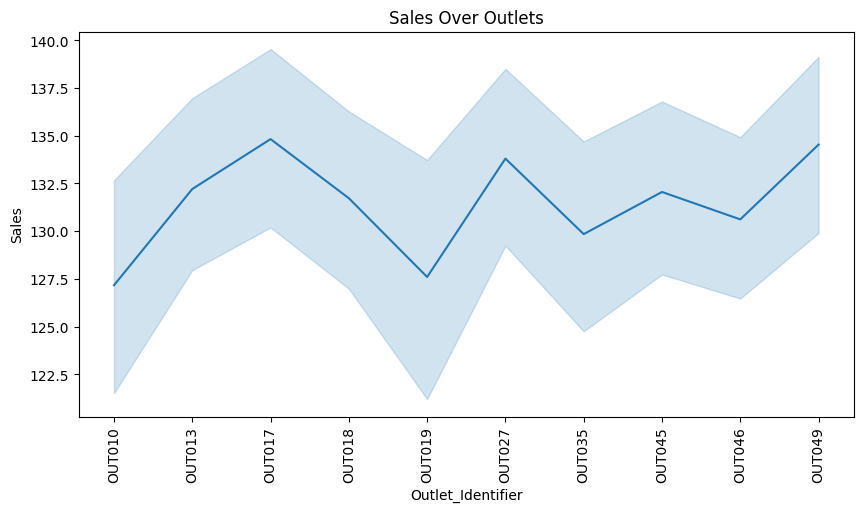

ARIMA: MAE=49.62, RMSE=59.62
SARIMA: MAE=49.54, RMSE=58.50
Random Forest: MAE=50.04, RMSE=59.14
XGBoost: MAE=50.04, RMSE=59.00


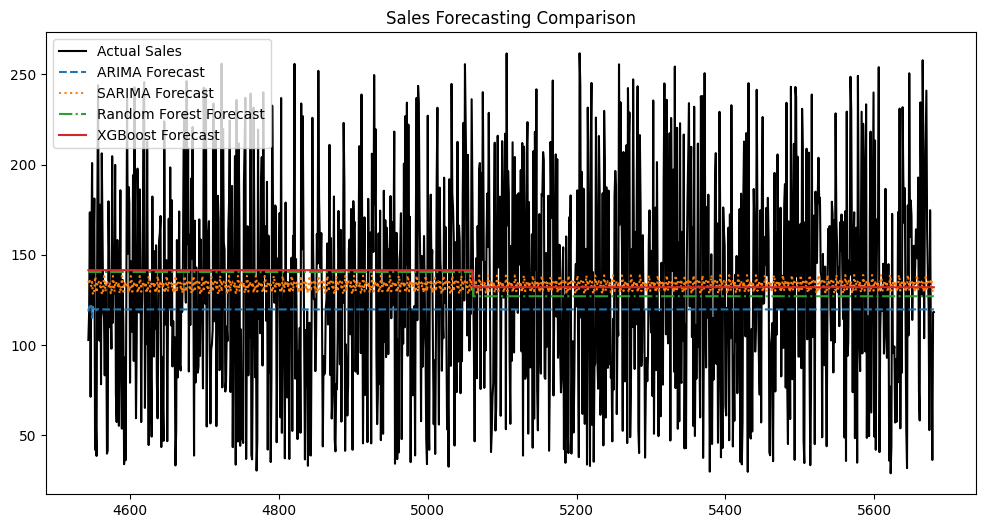

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

# Load dataset (replace with actual dataset path)
sales_data = pd.read_csv("sales.csv")

# Display the head of the DataFrame
print("Head of the DataFrame:")
display(sales_data.head())

# Check for null values
print("\nNull values in the DataFrame:")
print(sales_data.isnull().sum())

# Data preprocessing
sales_data['Outlet_Establishment_Year'] = pd.to_datetime(sales_data['Outlet_Establishment_Year'], format='%Y')
sales_data = sales_data.sort_values(by=['Outlet_Establishment_Year'])

# Aggregating sales data by Outlet Identifier and Item Identifier
sales_data['Sales'] = sales_data['Item_MRP'] * (1 - sales_data['Item_Visibility'])

# Calculate Outlet_Age before grouping
sales_data['Outlet_Age'] = 2024 - sales_data['Outlet_Establishment_Year'].dt.year

# Include Outlet_Age in the grouping
grouped_sales_data = sales_data.groupby(['Outlet_Identifier', 'Item_Identifier'])[['Sales', 'Outlet_Age']].agg({'Sales': 'sum', 'Outlet_Age': 'first'}).reset_index()

# Visualization (adjust to include Outlet_Age if desired)
plt.figure(figsize=(10, 5))
sns.lineplot(data=grouped_sales_data, x='Outlet_Identifier', y='Sales')
plt.title("Sales Over Outlets")
plt.xticks(rotation=90)
plt.show()

# Splitting Data
train_data_size = int(len(grouped_sales_data) * 0.8)
train_data, test_data = grouped_sales_data.iloc[:train_data_size], grouped_sales_data.iloc[train_data_size:]

# ARIMA Model
arima_model = ARIMA(train_data["Sales"], order=(5, 1, 0))
arima_results = arima_model.fit()
arima_predictions = arima_results.forecast(steps=len(test_data))

# SARIMA Model
sarima_model = SARIMAX(train_data["Sales"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()
sarima_predictions = sarima_results.forecast(steps=len(test_data))

# Prepare data for ML models - Outlet_Age is now available
X_train_data, X_test_data, y_train_data, y_test_data = train_data[['Outlet_Age']], test_data[['Outlet_Age']], train_data['Sales'], test_data['Sales']

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_data, y_train_data)
rf_predictions = rf_model.predict(X_test_data)

# XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_data, y_train_data)
xgb_predictions = xgb_model.predict(X_test_data)

# Evaluation Function
def evaluate_model(actual_values, predicted_values, model_name):
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = sqrt(mean_squared_error(actual_values, predicted_values))
    print(f"{model_name}: MAE={mae:.2f}, RMSE={rmse:.2f}")

# Evaluate all models
evaluate_model(test_data['Sales'], arima_predictions, "ARIMA")
evaluate_model(test_data['Sales'], sarima_predictions, "SARIMA")
evaluate_model(y_test_data, rf_predictions, "Random Forest")
evaluate_model(y_test_data, xgb_predictions, "XGBoost")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["Sales"], label="Actual Sales", color="black")
plt.plot(test_data.index, arima_predictions, label="ARIMA Forecast", linestyle="dashed")
plt.plot(test_data.index, sarima_predictions, label="SARIMA Forecast", linestyle="dotted")
plt.plot(test_data.index, rf_predictions, label="Random Forest Forecast", linestyle="dashdot")
plt.plot(test_data.index, xgb_predictions, label="XGBoost Forecast", linestyle="solid")
plt.legend()
plt.title("Sales Forecasting Comparison")
plt.show()